# Import libraries

In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.applications.mobilenet_v2 as mobilenet

from pathlib import Path
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparation data

In [2]:
BATCH_SIZE = 16
IMG_SHAPE = 128
IMAGE_SIZE = (128, 128, 3)

path_base = r"D:\KWork\ReCaptcher"

file_source = Path(path_base) / "base"
train_file_destination = Path(path_base) / "data" / "train"
val_file_destination = Path(path_base) / "data" / "validation"

In [3]:
gen_data = ImageDataGenerator(
    preprocessing_function=mobilenet.preprocess_input,
    rotation_range=5, width_shift_range=0.1,
    height_shift_range=0.02, zoom_range=0.15,
    fill_mode="nearest"
)

train_dir = train_file_destination
val_dir = val_file_destination

train_data_gen = gen_data.flow_from_directory(
    directory=train_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE, shuffle=True, class_mode="sparse"
)

val_data_gen = gen_data.flow_from_directory(
    directory=val_dir, target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE, shuffle=True, class_mode="sparse"
)

Found 3809 images belonging to 8 classes.
Found 1629 images belonging to 8 classes.


# Tuning model

In [4]:
def get_compiled_model(dropout=0.2, lr=1e-4):
    
    base_model = mobilenet.MobileNetV2(
        include_top=False, weights="imagenet", input_shape=IMAGE_SIZE
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(rate=dropout),
        tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model

In [5]:
import gdown

url_weights = "https://drive.google.com/uc?id=1ufwMlYLgbNfBN9ZSpiEBf3kRP2Wzfr1N"
output_weights = r"weights.hdf5"

gdown.download(url_weights, output_weights, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ufwMlYLgbNfBN9ZSpiEBf3kRP2Wzfr1N
To: D:\KWork\ReCaptcher\weights.hdf5
100%|█████████████████████████████████████████████████████████████████████████████| 9.47M/9.47M [00:01<00:00, 5.40MB/s]


'weights.hdf5'

In [6]:
tune_model = get_compiled_model(dropout=0.6, lr=1.5e-7)
tune_model.load_weights(output_weights)
tune_model.evaluate(val_data_gen)

102/102 [==============================] - 18s 126ms/step - loss: 0.5581 - accuracy: 0.8072


[0.5581368803977966, 0.8072437047958374]

In [8]:
TUNE_N_LAYERS = 0

tune_model.layers[0].trainable = True

for layer in tune_model.layers[0].layers[:TUNE_N_LAYERS]:
    layer.trainable = False

tune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 2,234,120
Non-trainable params: 34,112
_________________________________________________________________


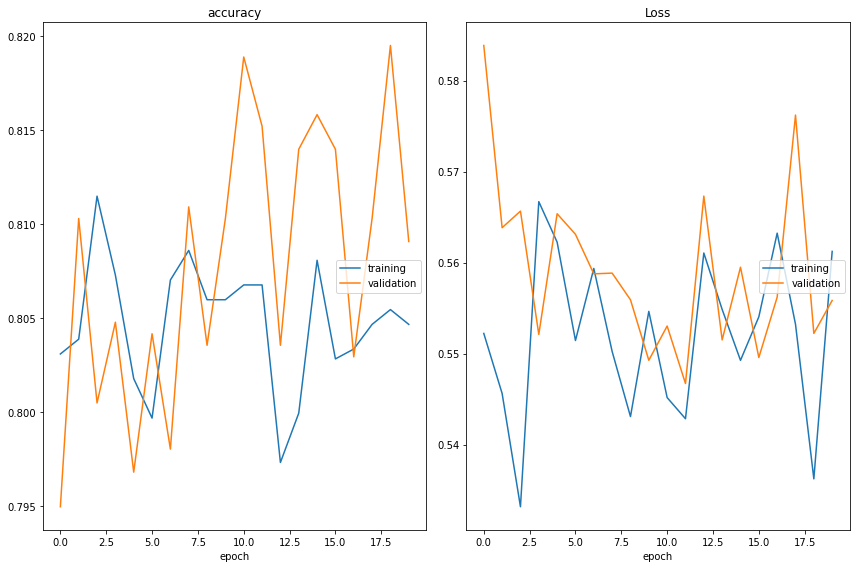

accuracy
	training         	 (min:    0.797, max:    0.811, cur:    0.805)
	validation       	 (min:    0.795, max:    0.820, cur:    0.809)
Loss
	training         	 (min:    0.533, max:    0.567, cur:    0.561)
	validation       	 (min:    0.547, max:    0.584, cur:    0.556)

Epoch 00020: val_accuracy did not improve from 0.81952


In [9]:
EPOCHS = 20

checkpoint_path = r"tune_model/best_model.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_accuracy", verbose=1, 
    save_best_only=True, mode="max"
)

tune_model.fit(
    train_data_gen, validation_data=val_data_gen,
    epochs=EPOCHS, callbacks=([PlotLossesCallback(), checkpoint])
)